## A/B-тестирование

Поступила аналитическая задача от международного интернет-магазина, предшественник не закончил её — запустил А/B-тест и уволился. Осталось только техническое задание и результаты теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- Группы: А (контрольная), B (новая платежная воронка);
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эфект: за 14 дней с момента регистрации в системе пользователи покажут лучшую конверсию в просмотр карточек товаров (событие `product_page`), просмотр  корзины товаров (событие `product_card`) и покупку (`purchase`). На каждом из шагов воронки `product_page → product_card → purchase` улучшение составит не менее 10%;
- Ожидаемое количество участников теста: 6000.

Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

### Описание данных
- `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;
- `final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
- `final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- `final_ab_participants.csv` — таблица участников тестов.

Структура файла `ab_project_marketing_events.csv`:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Структура файла `final_ab_new_users.csv`:

- `user_id` — уникальный идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион, к которому относится пользователь;
- `device` — устройство, с которого происходила регистрация.

Структура файла `final_ab_events.csv`:

- `user_id` — уникальный идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — наименование типа события;
- `details` — дополнительные данные о событии. Например, в этом поле хранится стоимость покупки (USD) для события «покупка» (`purchase`);

Структура файла `final_ab_participants.csv`:

- `user_id` — уникальный идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа, в которой находился пользователь в рамках теста.

### План работы
1. Описание целей исследования
2. Исследование данных
    1. Преобразование типов
    2. Исследование пропусков и дубликатов
3. EDA
    1. Исследование конверсии в воронке на разных этапах
    2. Исследование распределения количества событий на пользователя в разных выборках
    3. Присутствуют ли в выборках одни и те же пользователи?
    4. Исследование распределения числа событий по дням
4. Проведение оценки результатов A/B-тестирования
    1. Исследование результатов A/A-тестирования
    2. Проверка статистической разницы долей z-критерием
5. Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования

## 1. Цели исследования

Ключевая цель исследования, проверить наличие значимых статистических различий между двумя тестовыми группами, и установить, в какой группе пользователи показывают лучшую конверсию; исследовать распределение пользователей в группах, узнать, как меняется кумулятивная конверсия и число событий по дням.

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.io as pio
pio.renderers.default = "svg"

## 2. Загрузка и изучение данных

In [3]:
cl = pd.read_csv('ab_project_marketing_events.csv')
users = pd.read_csv('final_ab_new_users.csv')
events = pd.read_csv('final_ab_events.csv')
part = pd.read_csv('final_ab_participants.csv')
for i in [cl, users, events, part]:
    i.drop('Unnamed: 0', axis=1, inplace=True)

**Исследование данных и преобразование типов**

In [4]:
def information(df):
    display(df.head())
    print()
    df.info()
    print()
    print('Число дубликатов:', df.duplicated().sum())

In [5]:
cl.sort_values(by='start_dt').reset_index(drop=True)

,name,regions,start_dt,finish_dt
0,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
3,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
4,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
6,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
7,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
8,4th of July Promo,N.America,2020-07-04,2020-07-11
9,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Перед нами календарь маркетинговых событий, всего 14 записей, подробно концентрироваться на его изучении не будем.

In [6]:
information(users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Число дубликатов: 0


Датасет с записями о пользователях, всего 61733 запись, пропусков нет, дубликатов нет. Преобразуем даты к типу datetime:

In [7]:
users['first_date'] = pd.to_datetime(users['first_date'])

In [8]:
information(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Число дубликатов: 0


Датасет с записями о событиях, всего 440317 запись, есть пропуски, нет дубликатов. Преобразуем даты к типу datetime, а также изучим природу пропусков:

In [9]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events['event_day'] = events['event_dt'].dt.date

In [10]:
display(events.groupby('event_name')['details'].mean().to_frame(name='mean').round(2))
display(events.groupby('event_name')['details'].value_counts(dropna=False).to_frame())

,mean
event_name,
login,NaN
product_cart,NaN
product_page,NaN
purchase,23.88


details
event_name   details         
login        NaN       189552
product_cart NaN        62462
product_page NaN       125563
purchase     4.99       46362
             9.99        9530
             99.99       5631
             499.99      1217

Таким образом наличие пропусков логично, поскольку данные о стоимости покупки записаны только для события purchase.

In [11]:
information(part)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Число дубликатов: 0


In [12]:
part['ab_test'].value_counts().to_frame()

,ab_test
interface_eu_test,11567
recommender_system_test,6701


In [13]:
part['group'].value_counts(normalize=True).to_frame()

,group
A,0.52852
B,0.47148


В последнем датасете содержатся данные о пользователях из двух тестов: `interface_eu_test` и `recommender_system_test`, разбитых на группы A и B. В нем отсутсвуют пропуски и дубликаты.

### Вывод

На этом этапе были загружены данные и изучены датасеты. Почти во всех датасетах отсуствуют пропуски и дубликаты. В датасете о событиях есть пропуски но их наличие логично, поскольку данные о стоимости товаров содержатся только в событии покупки. Столбцы с датами преобразованы к типу datetime.

## 3. Исследовательский анализ данных

Смержим датасеты `part`, `events`, `users` по пользователям теста `recommender_system_test`:

In [14]:
ab = part[part['ab_test'] == 'recommender_system_test']
ab = ab.merge(events, on='user_id', how='left')
print('Число уникальных записей во всех столбцах после слияния "part" и "events":')
display(ab.nunique())
print('Число пропусков:')
display(ab.isna().sum())

Число уникальных записей во всех столбцах после слияния "part" и "events":


user_id        6701
group             2
ab_test           1
event_dt      16523
event_name        4
details           4
event_day        24
dtype: int64

Число пропусков:


user_id           0
group             0
ab_test           0
event_dt       3026
event_name     3026
details       24393
event_day      3026
dtype: int64

In [15]:
ab = ab.merge(users, on=['user_id'], how='left')
print('Число пропусков после мержа трех датасетов:')
display(ab.isna().sum())
ab.info()
display(ab.head())

Число пропусков после мержа трех датасетов:


user_id           0
group             0
ab_test           0
event_dt       3026
event_name     3026
details       24393
event_day      3026
first_date        0
region            0
device            0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 27723
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   group       27724 non-null  object        
 2   ab_test     27724 non-null  object        
 3   event_dt    24698 non-null  datetime64[ns]
 4   event_name  24698 non-null  object        
 5   details     3331 non-null   float64       
 6   event_day   24698 non-null  object        
 7   first_date  27724 non-null  datetime64[ns]
 8   region      27724 non-null  object        
 9   device      27724 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 2.3+ MB


,user_id,group,ab_test,event_dt,event_name,details,event_day,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-25,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,2020-12-07,EU,PC


В новом датасете образовались пропуски, это связано с тем, что не для каждого пользователя были записи в другом датасете. Например в столбце event_name это может говорить о том, что пользователи не попали в воронку событий, потому что не прошли логгирование в систему, то же самое относится и к датам, система записывала время наступления события воронки. В поле details логично наличие данных только для события purchase. Таким образом, наличие пропусков логично, никак их не будем обрабатывать, в дальнейшей работе будем их фильтровать. 

**Исследование конверсии в воронке на разных этапах**

Посмотрим как распределены события по тестовым группам A и B:

In [16]:
def counts(df, group, state):
    return df.query('group == @group')['event_name'].value_counts(normalize=state).to_frame(name=group).sort_values(by=group,ascending=False)
def funnel(data, name):
    graph = go.Funnel(
         y=data[data.columns[0]],
         x=data[data.columns[1]], textinfo = "value+percent initial", name=name)
    return graph

In [17]:
gr_ab = counts(ab, 'A', False).join(counts(ab, 'A', True).add_suffix('_norm'))\
.join(counts(ab, 'B', False)).join(counts(ab, 'B', True).add_suffix('_norm'))\
.style.format({'A_norm':'{:.1%}', 'B_norm':'{:.1%}'})
display(gr_ab)

,A,A_norm,B,B_norm
login,8566,44.4%,2624,48.6%
product_page,5525,28.6%,1405,26.0%
purchase,2655,13.8%,676,12.5%
product_cart,2558,13.3%,689,12.8%


Здесь можно заметить, что для группы A событий покупок больше, чем событий просмотра корзины товаров. Возможно, это связано с тем, что покупку можно совершать не обязательно через корзину. 

Построим графики воронок для распределения событий в двух группах суммарно и отдельно в группах A и B:

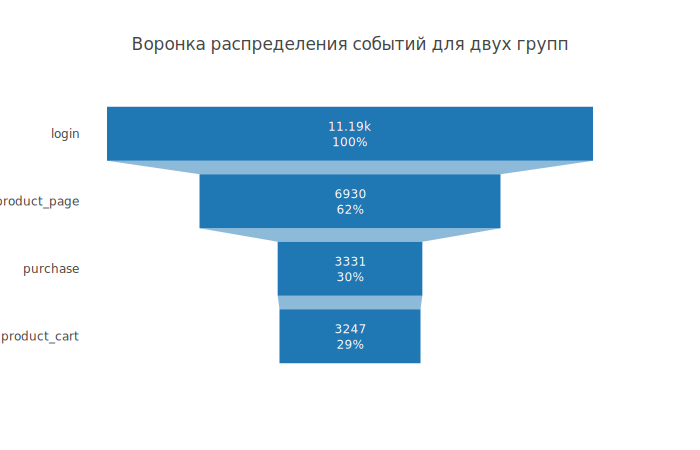

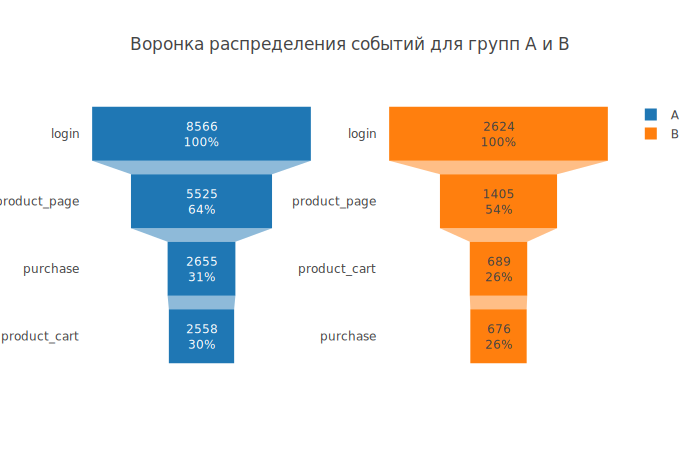

In [18]:
data1 = ab['event_name'].value_counts().reset_index().rename(columns={'index':'event_name', 'event_name':'count'})
data2 = counts(ab, 'A', False).reset_index()
data3 = counts(ab, 'B', False).reset_index()
fig = go.Figure(funnel(data1, 'Две группы'))
fig.update_layout(
        title={
            'text': 'Воронка распределения событий для двух групп'}, template=None)
fig.show()
fig = make_subplots(rows=1, cols=2)
fig.add_trace(funnel(data2, "A"), row=1, col=1)
fig.add_trace(funnel(data3, 'B'), row=1, col=2)
fig.update_layout(
        title={
            'text': 'Воронка распределения событий для групп A и B'}, template=None)
fig.show()

На графиках представлена визуализация записей о событиях. Для двух групп совершено суммарно 11.19k логгирований (`login`), затем совершено 6930 просмотров карточек товаров (событие `product_page`), затем пользователи попадают в корзину товаров `product_card` (3247), либо минуют корзину и сразу оплачивают (событие `purchase`) - 3331 запись для пользователей двух групп.

В среднем 30% событий конвертируются в покупки, 31% для A и 30% B.

Изучим подробнее кумулятивную конверсию за весь период теста, для этого построим графики кумулятивной конверсии для двух групп и относительного различия конверсий:

In [19]:
datesGroups = ab[['event_day','group']].drop_duplicates().dropna()
ordersAggregated = datesGroups.apply(lambda x: ab[(ab['event_day'] <= x['event_day']) & (ab['group'] == x['group'])]\
.agg({'event_day' : 'max', 'group' : 'max', 'user_id' : 'nunique', 'details' : 'sum', 'event_name':'count'}), axis=1)\
.sort_values(by=['event_day','group']).reset_index(drop=True).rename(columns={'user_id':'total_users', 'event_name':'total_events'})

buyers = (datesGroups.apply(lambda x: ab[(ab['event_day'] <= x['event_day']) 
                                         & (ab['group'] == x['group']) 
                                         & (ab['event_name'] == 'purchase')]
                            .agg({'event_day' : 'max', 'group' : 'max', 'user_id' : 'nunique', 'event_name':'count'}), 
                            axis=1)
          .sort_values(by=['event_day','group'])
          .reset_index(drop=True)
          .rename(columns={'user_id':'total_bueyers', 'event_name':'count_purchases'}))

cumm_data = ordersAggregated.merge(buyers, on=['event_day', 'group'])
cumm_data['cr_to_purchase'] = (cumm_data['total_bueyers'] / cumm_data['total_users']).round(3)
display(cumm_data.head())

,event_day,group,total_users,details,total_events,total_bueyers,count_purchases,cr_to_purchase
0,2020-12-07,A,154,1214.54,331,46,46,0.299
1,2020-12-07,B,173,704.41,378,59,59,0.341
2,2020-12-08,A,256,1994.17,672,72,83,0.281
3,2020-12-08,B,220,1199.06,630,71,94,0.323
4,2020-12-09,A,340,3363.66,1057,95,134,0.279


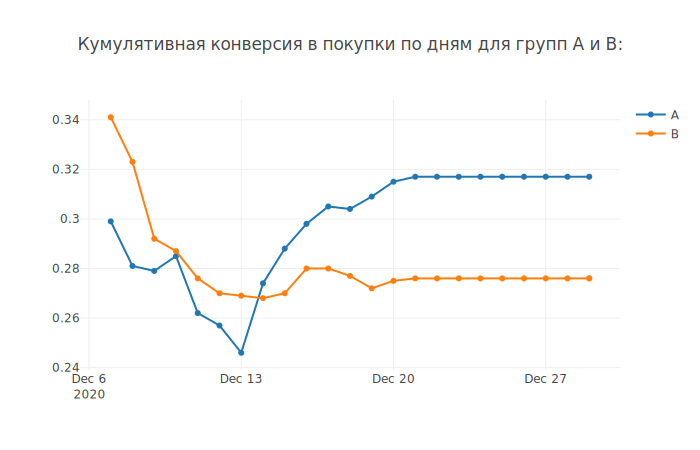

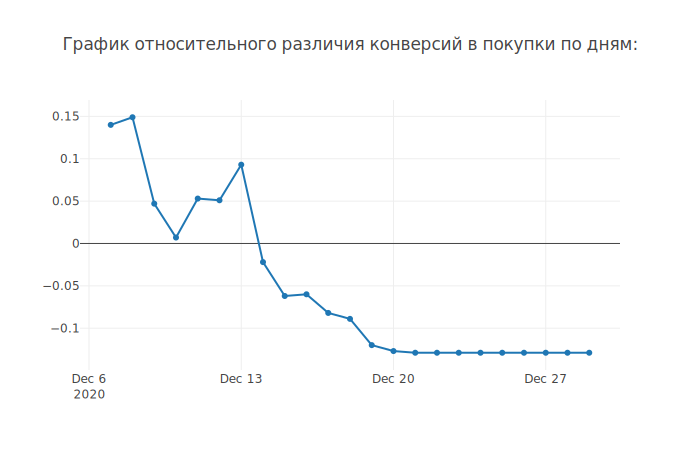

In [20]:
lineplot = []
for i in cumm_data['group'].unique():
    graph = cumm_data.query('group == @i')
    lineplot.append(go.Scatter(x=graph['event_day'],y=graph['cr_to_purchase'], mode='lines+markers', name=i))
fig = go.Figure(data=lineplot)
fig.update_layout(template=None, title={'text': 'Кумулятивная конверсия в покупки по дням для групп A и B:'})
fig.show()

a_group = cumm_data.query('group=="A"').reset_index(drop=True)
b_group = cumm_data.query('group=="B"').reset_index(drop=True)
rel_diff = ((b_group['cr_to_purchase'] / a_group['cr_to_purchase']) - 1 ).round(3).dropna()
gr = [go.Scatter(x=a_group['event_day'],y=rel_diff, mode='lines+markers')]
fig = go.Figure(data=gr)
fig.update_layout(template=None, title={'text': 'График относительного различия конверсий в покупки по дням:'})
fig.show()

Видно, что по результатам первой недели конверсии сильно колеблются, но начиная с 20го декабря полностью выравниваются. Группа A лидирует с 0.317 до конца теста, группа B начинает проигрывать с 14го декабря, что хорошо видно на графике относительного различия конверсий, после 18го декабря конверсия экспериментальной группы B становится стабильно ниже на 10% конверсии контрольной группы A.

**Узнаем, обладают ли выборки одинаковыми распределениями количества событий на пользователя**

Для начала исследуем распределение событий для всех пользователей в двух группах:

In [21]:
def distribution(df):
    ev_by_user = df.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id',ascending=False)\
.assign(cr_initial = lambda x: (x['user_id'] / x['user_id'].max()).map(lambda x: '{:.1%}'.format(x)),
            cr_prev = lambda x: (x['user_id'].pct_change()+1).fillna(value=1).apply(lambda x: '{:.1%}'.format(x)),
       cr_all = lambda x: (x['user_id']/ df['user_id'].nunique()).map(lambda x: '{:.1%}'.format(x)))\
    .rename(columns={'user_id': 'count'})
    return ev_by_user

In [22]:
print("Всего уникальных пользователей:", ab['user_id'].nunique())

Всего уникальных пользователей: 6701


Уникальных пользователй в двух группах:

In [23]:
ab_all = ab.groupby('group')['user_id'].nunique().to_frame()
display(ab_all)

,user_id
group,
A,3824
B,2877


In [24]:
distribution(ab)

,count,cr_initial,cr_prev,cr_all
event_name,,,,
login,3675,100.0%,100.0%,54.8%
product_page,2303,62.7%,62.7%,34.4%
purchase,1128,30.7%,49.0%,16.8%
product_cart,1079,29.4%,95.7%,16.1%


Видно, что на этап `login` попало меньше пользователей, всего 3675, вместо 6k+. Узнаем в чем причина:

In [25]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 27723
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   group       27724 non-null  object        
 2   ab_test     27724 non-null  object        
 3   event_dt    24698 non-null  datetime64[ns]
 4   event_name  24698 non-null  object        
 5   details     3331 non-null   float64       
 6   event_day   24698 non-null  object        
 7   first_date  27724 non-null  datetime64[ns]
 8   region      27724 non-null  object        
 9   device      27724 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 2.3+ MB


В столбце с событиями `event_name` есть пропущенные значения, вероятно это связано с тем, что не все пользователи заходили в систему. 

Число уникальных пользователей, которые попали в события воронки в двух группах:

In [26]:
ab_event = ab[~ab['event_name'].isna()].groupby('group')['user_id'].nunique().to_frame()
display(ab_event)

,user_id
group,
A,2747
B,928


In [27]:
null_users = ab_all.sum()[0] - ab_event.sum()[0]
print('Число пользователей, не попавших в воронку событий:', null_users)
print('Общее число уникальных пользователей, принимающих участие в тесте:', ab_event.sum()[0])

Число пользователей, не попавших в воронку событий: 3026
Общее число уникальных пользователей, принимающих участие в тесте: 3675


Посмотрим, как пользователи конвертируются в разные события в двух группах:

In [28]:
def add_diff(df, col_A, col_B):
        df = df.assign(count_diff_AB = lambda x: (1 - x[col_B]/ x[col_A]).map(lambda x: '{:.1%}'.format(x)),
                   cr_diff_AB = lambda x: ((x[col_A] / x[col_A].max()) - (x[col_B] / x[col_B].max()))
                    .map(lambda x: '{:.1%}'.format(x)))
        return df
A = distribution(ab.query('group =="A"')).add_suffix('_A')
B = distribution(ab.query('group =="B"')).add_suffix('_B')
ab_user_funn = A.join(B)
ab_user_funn = add_diff(ab_user_funn,'count_A', 'count_B')
ab_user_funn = ab_user_funn[ab_user_funn.columns.sort_values()]
display(ab_user_funn)

,count_A,count_B,count_diff_AB,cr_all_A,cr_all_B,cr_diff_AB,cr_initial_A,cr_initial_B,cr_prev_A,cr_prev_B
event_name,,,,,,,,,,
login,2747,928,66.2%,71.8%,32.3%,0.0%,100.0%,100.0%,100.0%,100.0%
product_page,1780,523,70.6%,46.5%,18.2%,8.4%,64.8%,56.4%,64.8%,56.4%
purchase,872,256,70.6%,22.8%,8.9%,4.2%,31.7%,27.6%,49.0%,48.9%
product_cart,824,255,69.1%,21.5%,8.9%,2.5%,30.0%,27.5%,94.5%,99.6%


Для группы A - 21.5% всех пользователей являются покупателями, соответственно попали во все события; также 31.7% пользователей, которые залогинились в систему стали покупателями и участвовали во всех события 30% залогиненных. Для группы B - 9% всех пользователей являются покупателями, 27% залогиненных являются покупателями и были на всех этапах воронки. В группе А в среднем больше пользователей на 70%. Разница в конверсии колеблется от 2.5% до 8.4%.
Большая часть пользователей группы B не попала в воронку, вероятно это могло быть связано с каким-то багом системы.

Среднее число событий на пользователя, `mean_events_total` для всех пользователей из каждой группы  и `mean_events` для пользователей, которые попали в воронку:

In [29]:
ab.groupby(['user_id','group'], as_index=False)['event_name'].count().groupby('group')['event_name'].mean()\
.round(2).to_frame(name='mean_events_total')\
.join(ab[~ab['event_name'].isna()].groupby(['user_id','group'], as_index=False)['event_name'].count()\
      .groupby('group')['event_name'].mean()\
.round(2).to_frame(name='mean_events'))

,mean_events_total,mean_events
group,,
A,5.05,7.03
B,1.87,5.81


Среднее число событий на пользователя в группе A составляет 7, в группе B - 5.8. Узнаем, есть ли статистические различия между двумя группами. Посмотрим, как значения распределены на диаграмме размаха:

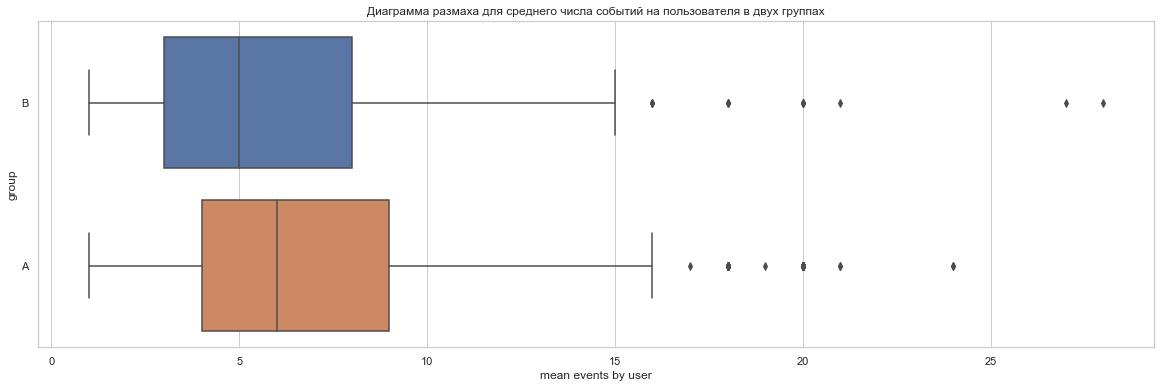

In [30]:
plt.subplots(figsize=(20, 6))
mean_events = ab[~ab['event_name'].isna()].groupby(['user_id','group'], as_index=False)['event_name'].count()
sns.boxplot(data=mean_events, x='event_name', y='group')
plt.xlabel('mean events by user')
plt.title('Диаграмма размаха для среднего числа событий на пользователя в двух группах')
plt.show()

Для обеих групп в выборках присутствуют выбросы, чтобы игнорировать их, будем использовать непараметрический критерий Манна-Уитни, который устойчив к выбросам, порог alpha установим равным 0.05. Сформирмурем нулевую и альтернативную гипотезы:

- H(0) - нет значимых статистических различий между группами A и B для среднего числа событий на пользователя
- H(1) - есть значимые статистические различия между группами A и B для среднего числа событий на пользователя

In [31]:
alpha = 0.05
p_value = st.mannwhitneyu(mean_events.query('group=="A"')['event_name'], 
                          mean_events.query('group=="B"')['event_name'])[1]
if p_value < alpha:
    print('Принимаем альтернативную гипотезу, между группами есть значимые статистические различия')
else:
    print('Принимаем нулевую гипотезу, между группами нет значимых статистических различий')

Принимаем альтернативную гипотезу, между группами есть значимые статистические различия


Таким образом можно сделать вывод, что по среднему числу событий на пользователя в двух группах мы имеем значимые статистические различия. 

**Узнаем, присутствуют ли в выборках одни и те же пользователи?**

In [32]:
two_groups = ab.groupby('user_id')['group'].nunique().to_frame(name='count')
print('Число одних и тех же пользователей в двух выборках:', two_groups.query('count > 1').count()[0])

Число одних и тех же пользователей в двух выборках: 0


**Как число событий распределено по дням?**

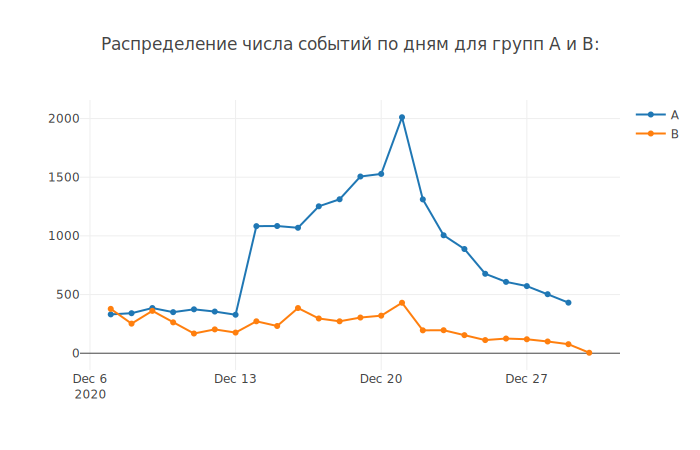

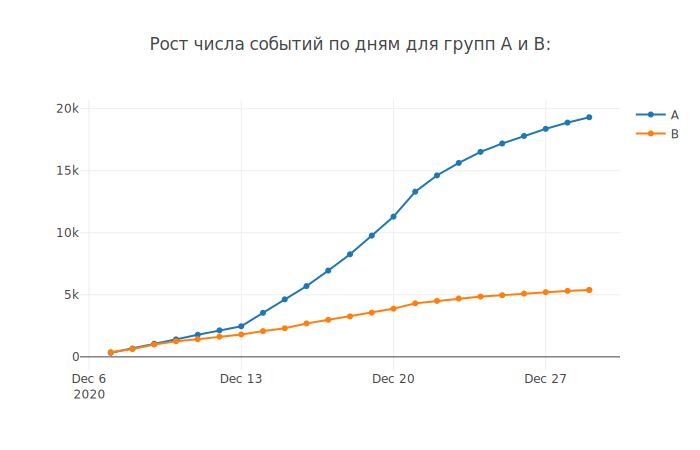

In [33]:
lineplot = []
for i in ab['group'].unique():
    graph = ab.query('group == @i').groupby('event_day')['event_name'].count().reset_index()
    lineplot.append(go.Scatter(x=graph['event_day'],y=graph['event_name'], mode='lines+markers', name=i))

fig = go.Figure(data=lineplot)
fig.update_layout(template=None, title={'text': 'Распределение числа событий по дням для групп A и B:'})
fig.show()


lineplot = []
for i in cumm_data['group'].unique():
    graph = cumm_data.query('group == @i')
    lineplot.append(go.Scatter(x=graph['event_day'],y=graph['total_events'], mode='lines+markers', name=i))
fig = go.Figure(data=lineplot)
fig.update_layout(template=None, title={'text': 'Рост числа событий по дням для групп A и B:'})
fig.show()

Группа A выигрывает по числу событий, как минимум потому, что в ней больше активных пользователей, чем в группе B. Пик приходится на 21 декабря, возможно такая активность связана с наступающим рождеством.

**Посмотрим, есть ли какие-то нюансы данных, которые нужно учесть, прежде чем приступать к A/B-тестированию:**

На прошлых шагах было выяснено, что не все пользователи попали в воронку событий, поэтому проверку гипотезу будем осуществлять только по тем пользователям, которые попали в воронку.

In [34]:
display(ab_user_funn[['count_A','count_B']])

,count_A,count_B
event_name,,
login,2747,928
product_page,1780,523
purchase,872,256
product_cart,824,255


### Вывод

На этом этапе создали датасет, смерженный из трех, с записями о тестовых группах, пользователях и событиях. Исследовали распределение пользователей по группам и событиям, исследовали кумулятивную конверсию:

- Для группы A событий покупок больше, чем событий просмотра корзины товаров. Возможно, это связано с тем, что покупку можно совершать не обязательно через корзину.
- В среднем 30% событий конвертируются в покупки, 31% для A и 30% B.
- По результатам первой недели теста конверсии сильно колеблются, но начиная с 20-го декабря полностью выравниваются. Группа A лидирует с 0.317 до конца теста, группа B начинает проигрывать с 14-го декабря, после 18-го декабря конверсия экспериментальной группы B становится стабильно ниже на 10% конверсии контрольной группы A.
- Общее число уникальных пользователей, принимающих участие в тесте: 3675
- Для группы A - 21.5% всех пользователей являются покупателями, соответственно попали во все события; также 31.7% пользователей, которые залогинились в систему стали покупателями и участвовали во всех события 30% залогиненных. Для группы B - 9% всех пользователей являются покупателями, 27% залогиненных являются покупателями и были на всех этапах воронки. В группе А в среднем больше пользователей на 70%. Разница в конверсии колеблется от 2.5% до 8.4%. Большая часть пользователей группы B не попала в воронку, вероятно это могло быть связано с каким-то багом системы.
- Группа A выигрывает по числу событий, как минимум потому что в ней больше активных пользователей, чем в группе B. Пик событий приходится на 21 декабря, возможно такая активность связана с наступающим рождеством.
- Среднее число событий на пользователя в группе A составляет 7, в группе B 5.8, число событий на пользователя в двух группах значимо различается.

## 4. Провединие оценки результатов A/B-тестирования

**Изучим результатов A/A-тестирования**

Для того чтобы провести A/A тест, разобъём выборку на 2 равные части:

In [35]:
div = int(ab[(ab['group']=="A") & ~ab['event_name'].isna()]['user_id'].nunique() / 2)
a1_userlist = (pd.Series(ab[(ab['group']=="A") & ~ab['event_name'].isna()]['user_id']
                         .unique()).sample(div, random_state=0).tolist())
a_1 = ab[ab['user_id'].isin(a1_userlist)]
a_2 = ab[~ab['user_id'].isin(a1_userlist) & ~ab['event_name'].isna() & (ab['group']=="A")]

In [36]:
print('Число записей в выборке A_1:', a_1.shape[0])
print('Число записей в выборке A_2:', a_2.shape[0])

Число записей в выборке A_1: 9579
Число записей в выборке A_2: 9725


Исследуем конверсии для двух групп:

In [37]:
aa = distribution(a_1).add_suffix('_a1').join(distribution(a_2).add_suffix('_a2'))
aa = add_diff(aa,'count_a1', 'count_a2').rename(columns={"cr_diff_AB":"cr_init_diff", "count_diff_AB":'count_diff'})
aa = aa[aa.columns.sort_values()]
display(aa)

,count_a1,count_a2,count_diff,cr_all_a1,cr_all_a2,cr_init_diff,cr_initial_a1,cr_initial_a2,cr_prev_a1,cr_prev_a2
event_name,,,,,,,,,,
login,1373,1374,-0.1%,100.0%,100.0%,0.0%,100.0%,100.0%,100.0%,100.0%
product_page,883,897,-1.6%,64.3%,65.3%,-1.0%,64.3%,65.3%,64.3%,65.3%
purchase,417,455,-9.1%,30.4%,33.1%,-2.7%,30.4%,33.1%,47.2%,50.7%
product_cart,416,408,1.9%,30.3%,29.7%,0.6%,30.3%,29.7%,99.8%,89.7%


Конверсия по группам не различается более чем на 2.7% на каждом этапе.

Проверим, будет ли отличие между группами a_1 и a_2 статистически достоверным для залогиненных пользователей:


Чтобы установить эквивалентность групп, напишем функцию для рассчета статистической значимости между долями и определим нулевую и альтернативную гипотезу. 
- H(0) - нет значимых статистических различий между группами a_1 и a_2 на каждом этапе событий
- H(1) - есть значимые статистические различия между группами a_1 и a_2 для одного и более событий

Пороговое значение установим аlpha=0.05, но так как будем проводить множественный тест, будет расти вероятность получить ошибку первого рода, поэтому применим поправку Бонферрони и разделим alpha на число проверяемых гипотез (будем сравнивать группы A/A, A/B в каждой по 3 сравнений, суммарно 6).

In [38]:
a1_users = aa.loc['login']['count_a1']
a2_users = aa.loc['login']['count_a2']
aa = aa.drop(['login'])

In [39]:
alpha = 0.05 / 6
print('Порог уровня значимости:', alpha)

Порог уровня значимости: 0.008333333333333333


In [40]:
def z_test(gr1,s1, gr2, s2):
    successes = np.array([s1, s2])
    trials = np.array([gr1, gr2])
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

**Проверим статистическую разницу долей z-критерием**

In [41]:
aa['aa_p-value'] = aa.apply\
(lambda x: z_test(a1_users, x['count_a1'], a2_users, x['count_a2']), axis=1)
aa['aa_difference'] = aa['aa_p-value'].apply(lambda x: 'есть различия' if x < alpha else 'нет различий')

In [42]:
aa[['aa_p-value','aa_difference']]

,aa_p-value,aa_difference
event_name,,
product_page,0.593757,нет различий
purchase,0.122447,нет различий
product_cart,0.729656,нет различий


На основе проведенного z-теста принимаем нулевую гипотезу, группы a_1 и a_2 эквивалентны, между ними нет значимых статистических различий.

Проделаем такое же сравнение для группы A и группы B и посмотрим, есть ли статистические различия. Сформируем нулевую и альтернативные гипотезы:
- H(0) - нет значимых статистических различий между группами A и B на каждом этапе событий
- H(1) - есть значимые статистические различия между группами A и B для одного и более событий

In [43]:
ab_user_funn

,count_A,count_B,count_diff_AB,cr_all_A,cr_all_B,cr_diff_AB,cr_initial_A,cr_initial_B,cr_prev_A,cr_prev_B
event_name,,,,,,,,,,
login,2747,928,66.2%,71.8%,32.3%,0.0%,100.0%,100.0%,100.0%,100.0%
product_page,1780,523,70.6%,46.5%,18.2%,8.4%,64.8%,56.4%,64.8%,56.4%
purchase,872,256,70.6%,22.8%,8.9%,4.2%,31.7%,27.6%,49.0%,48.9%
product_cart,824,255,69.1%,21.5%,8.9%,2.5%,30.0%,27.5%,94.5%,99.6%


In [44]:
A_users = ab_user_funn.loc['login']['count_A']
B_users = ab_user_funn.loc['login']['count_B']
ab_user_funn = ab_user_funn.drop(['login'])

In [45]:
ab_user_funn['ab_p-value'] = ab_user_funn.apply\
(lambda x: z_test(A_users, x['count_A'], B_users, x['count_B']), axis=1)
ab_user_funn['ab_difference'] = ab_user_funn['ab_p-value'].apply(lambda x: 'есть различия' if x < alpha else 'нет различий')

In [46]:
ab_user_funn[['ab_p-value','ab_difference']]

,ab_p-value,ab_difference
event_name,,
product_page,0.000004,есть различия
purchase,0.017592,нет различий
product_cart,0.145348,нет различий


Таким образом, по результатам z-теста принимаем нулевую гипотезу  для событий `product_cart` и `purchase`. Для этапа `product_page` принимаем альтернативную гипотезу, между группами A и B для этого события есть значимые статистические различия. 

## 5. Общий вывод

По результатам анализа A/B теста, получены следующие выводы:
- Есть значимые статистические различия между группами A и B на этапе `product_page`. 
- На основе полученных данных на предыдущем этапе при исследовании кумулятивной конверсии можно сделать вывод, что группа B проигрывает A:  по  результатам первой недели теста конверсии сильно колеблются, но начиная с 20-го декабря полностью выравниваются. Группа A лидирует с 0.317 до конца теста, группа B начинает проигрывать с 14-го декабря, после 18-го декабря конверсия экспериментальной группы B становится стабильно ниже на 10% конверсии контрольной группы A.